# CWT Algorithm

This notebook tutorial shows how to work with `CWT` algorithm for detecting gamma-ray sources.

You can find the [docs here](http://docs.gammapy.org/dev/api/gammapy.detect.CWT.html#gammapy.detect.CWT)
and [source code on GitHub here](https://github.com/gammapy/gammapy/blob/master/gammapy/detect/cwt.py) for better understanding how the algorithm is constructed. 

## Setup

On this section we just import some packages that can be used (or maybe not) in this tutorial. You can also see the versions of the packages in the outputs below and notice that this notebook was written on Python 2.7. Don't worry about that because the code is also Python 3 compatible. 

In [1]:
# Render our plots inline
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 5)

In [2]:
import sys
import numpy as np
import scipy as sp

print("Python version: " + sys.version)
print("Numpy version: " + np.__version__)
print("Scipy version: " + sp.__version__)

Python version: 3.6.0 | packaged by conda-forge | (default, Feb  9 2017, 14:36:55) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Numpy version: 1.16.0.dev0+65f15a5
Scipy version: 1.1.0


## CWT Algorithm. PlayGround

First of all we import the data which should be analysied.

In [12]:
import os
from astropy.io import fits
from astropy.coordinates import Angle, SkyCoord
from gammapy.maps import Map

filename = "$GAMMAPY_EXTRA/datasets/fermi_survey/all.fits.gz"

counts = Map.read(filename=filename, hdu="COUNTS")
background = Map.read(filename=filename, hdu="BACKGROUND")

width = Angle([20, 10], "deg")
position = counts.geom.center_skydir
counts = counts.cutout(position=position, width=width)
background = background.cutout(position=position, width=width)

data = dict(counts=counts, background=background)

(<matplotlib.figure.Figure at 0x7f752ee7ec18>,
 None)

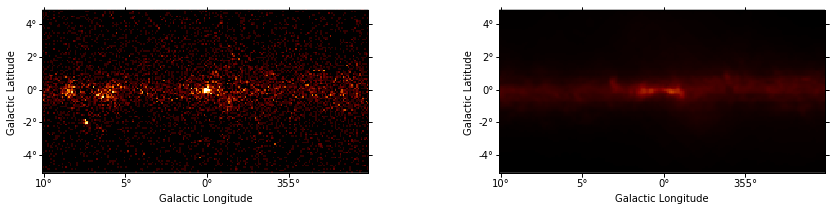

In [13]:
fig = plt.figure(figsize=(15, 3))

ax = fig.add_subplot(121, projection=data["counts"].geom.wcs)
data["counts"].plot(vmax=10, ax=ax, fig=fig)

ax = fig.add_subplot(122, projection=data["background"].geom.wcs)
data["background"].plot(vmax=10, ax=ax, fig=fig)

Let's explore how CWT works. At first define parameters of the algorithm.  An imperative parameter is kernels (`detect.CWTKernels` object). So we should create it.

In [14]:
# Input parameters for CWTKernels
N_SCALE = 2  # Number of scales considered.
MIN_SCALE = 6.  # First scale used.
STEP_SCALE = 1.3  # Base scaling factor.

In [15]:
from gammapy.detect import CWTKernels

cwt_kernels = CWTKernels(
    n_scale=N_SCALE, min_scale=MIN_SCALE, step_scale=STEP_SCALE
)
print(cwt_kernels.info_table)

                     Name                              Source        
---------------------------------------------- ----------------------
                              Number of scales                      2
                                 Minimal scale                    6.0
                                    Step scale                    1.3
                                        Scales              [6.  7.8]
                          Kernels approx width                     83
                            Kernels approx sum     0.9999153345163221
                            Kernels approx max  0.0015479047097235869
              Kernels base width for 6.0 scale                     63
                Kernels base sum for 6.0 scale 3.0166320971388447e-05
                Kernels base max for 6.0 scale  8.599470609575481e-05
Kernels base width for 7.800000000000001 scale                     83
  Kernels base sum for 7.800000000000001 scale  1.456141213300368e-05
  Kernels base max f

Other parameters are optional, in this demonstration define them all.

In [16]:
MAX_ITER = 10  # The maximum number of iterations of the CWT algorithm.
TOL = 1e-5  # Tolerance for stopping criterion.
SIGNIFICANCE_THRESHOLD = 2.  # Measure of statistical significance.
SIGNIFICANCE_ISLAND_THRESHOLD = (
    None
)  # Measure is used for cleaning of isolated pixel islands.
REMOVE_ISOLATED = True  # If True, isolated pixels will be removed.
KEEP_HISTORY = True  # If you want to save images of all the iterations

Let's start to analyse input data. Import Logging module to see how the algorithm works during data analysis.

In [17]:
from gammapy.detect import CWT
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
cwt = CWT(
    kernels=cwt_kernels,
    tol=TOL,
    significance_threshold=SIGNIFICANCE_THRESHOLD,
    significance_island_threshold=SIGNIFICANCE_ISLAND_THRESHOLD,
    remove_isolated=REMOVE_ISOLATED,
    keep_history=KEEP_HISTORY,
)

In order to the algorithm was able to analyze source images, you need to convert them to a special format, i.e. create an CWTData object. Do this.

In [19]:
from gammapy.detect import CWTKernels, CWTData

cwt_data = CWTData(
    counts=data["counts"], background=data["background"], n_scale=N_SCALE
)

In [20]:
# Start the algorithm
cwt.analyze(cwt_data)

## Results of analysis

Look at the results of CWT algorithm. Print all the images.

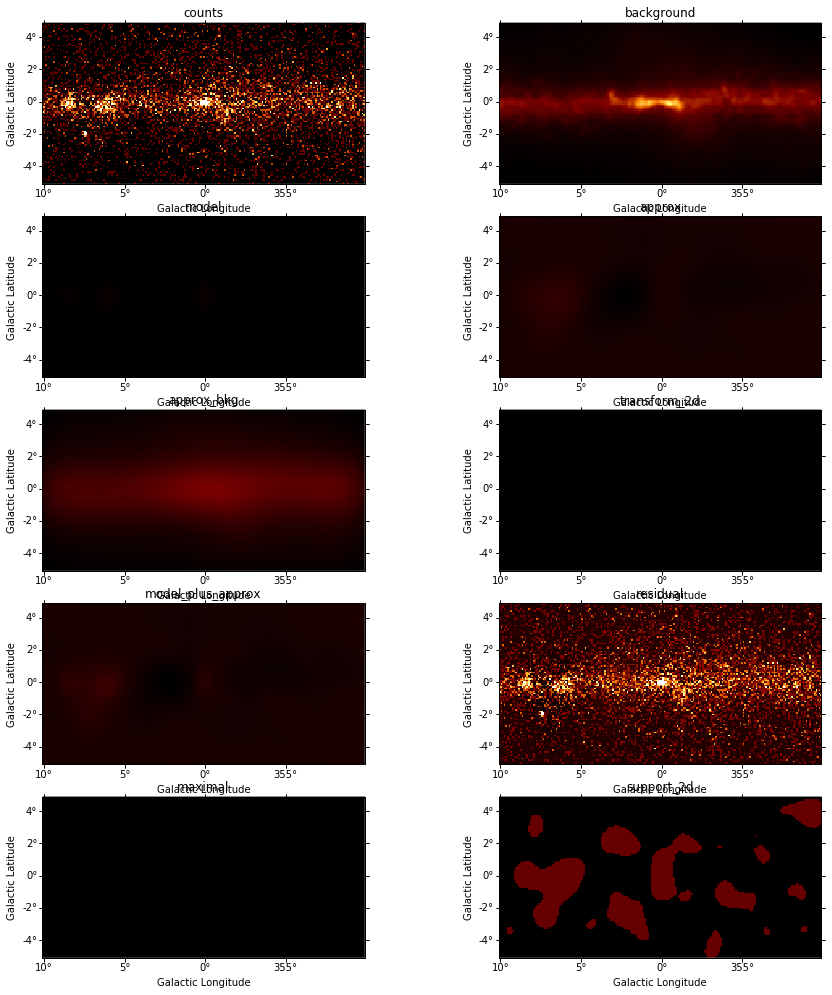

In [22]:
PLOT_VALUE_MAX = 5
FIG_SIZE = (15, 35)

fig = plt.figure(figsize=FIG_SIZE)
images = cwt_data.images()
for index, (name, image) in enumerate(images.items()):
    ax = fig.add_subplot(len(images), 2, index + 1, projection=image.geom.wcs)
    image.plot(vmax=PLOT_VALUE_MAX, fig=fig, ax=ax)
    plt.title(name)  # Maybe add a Name in SkyImage.plots?

As you can see in the implementation of CWT above, it has the parameter `keep_history`. If you set to it `True`-value, it means that CWT would save all the images from iterations. Algorithm keeps images of only last CWT start.  Let's do this in the demonstration.

In [23]:
history = cwt.history
print(
    "Number of iterations: {0}".format(len(history) - 1)
)  # -1 because CWT save start images too

Number of iterations: 10


Let's have a look, what's happening with images after the first iteration.

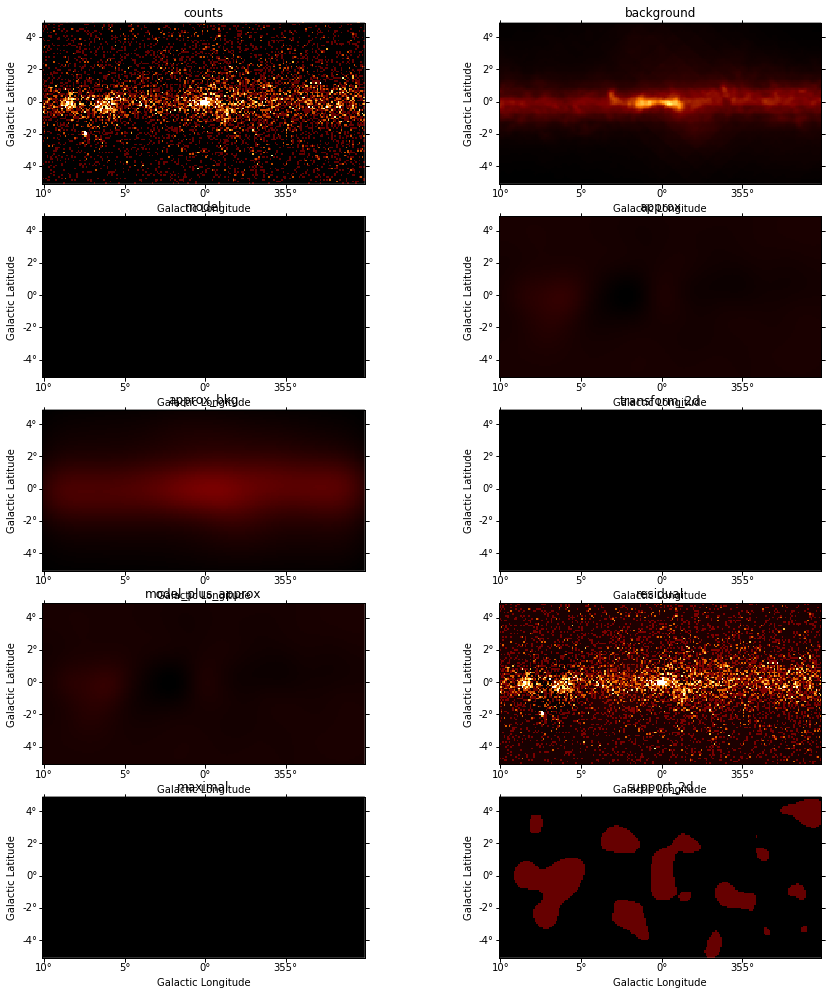

In [25]:
N_ITER = 1
assert 0 < N_ITER < len(history)
data_iter = history[N_ITER]

fig = plt.figure(figsize=FIG_SIZE)
images_iter = data_iter.images()
for index, (name, image) in enumerate(images_iter.items()):
    ax = fig.add_subplot(
        len(images_iter), 2, index + 1, projection=image.geom.wcs
    )
    image.plot(vmax=PLOT_VALUE_MAX, fig=fig, ax=ax)
    plt.title(name)  # Maybe add a Name in SkyImage.plots?

You can get the information about the one particular image in that way: 

In [26]:
print(data_iter.image_info(name="approx_bkg"))

 Metrics          Source      
---------- -------------------
      Name          approx_bkg
     Shape            2D image
  Variance  0.0800090238572501
      Mean  0.4230576474671889
 Max value   1.216320738970982
 Min value 0.03227949720410276
Sum values   8461.152949343777


You can also get the information about cubes. Or information about all the data. 

In [27]:
print(data_iter.cube_info(name="support", per_scale=True))

Scale power  Metrics          Source      
----------- ---------- -------------------
          1       Name             support
         --      Shape            2D image
         --   Variance 0.10030838999999998
         --       Mean              0.1131
         --  Max value                True
         --  Min value               False
         -- Sum values                2262
          2       Name             support
         --      Shape            2D image
         --   Variance 0.12255100000000002
         --       Mean               0.143
         --  Max value                True
         --  Min value               False
         -- Sum values                2860


In [28]:
print(data_iter.cube_info(name="support", per_scale=False))

 Metrics          Source      
---------- -------------------
      Name             support
     Shape             3D cube
  Variance 0.11165319750000001
      Mean             0.12805
 Max value                True
 Min value               False
Sum values                5122


Also you can see the difference betwen the iterations in that way:

In [29]:
history = cwt.history  # get list of 'CWTData' objects
difference = (
    history[1] - history[0]
)  # get new `CWTData` obj, let's work with them

In [30]:
print(difference.cube_info("support"))

 Metrics          Source      
---------- -------------------
      Name             support
     Shape             3D cube
  Variance 0.11165319750000001
      Mean             0.12805
 Max value                True
 Min value               False
Sum values                5122


In [31]:
difference.info_table.show_in_notebook()

idx,Name,Shape,Variance,Mean,Max value,Min value,Sum values
0,counts,2D image,0.6672141975,0.44445,24.0,0.0,8889.0
1,background,2D image,0.1652202535113842,0.45329956127341237,3.9148579308403715,0.09382170137317761,9065.991225468248
2,model,2D image,2.4686984587806902e-06,0.000455676406188641,0.015432799337676485,0.0,9.11352812377282
3,approx,2D image,0.004022666598226333,-0.00804611016777641,0.2713385823751632,-0.25176538416394356,-160.92220335552818
4,approx_bkg,2D image,0.0800090238572501,0.4230576474671889,1.216320738970982,0.03227949720410276,8461.152949343777
5,transform_2d,2D image,2.4686984587806902e-06,0.000455676406188641,0.015432799337676485,0.0,9.11352812377282
6,model_plus_approx,2D image,0.0041154670271407465,-0.007590433761587769,0.2851332425907042,-0.25176538416394356,-151.8086752317554
7,residual,2D image,0.66630009231829,0.4520404337615878,23.943554761680172,-0.28358481474609365,9040.808675231756
8,maximal,2D image,1.2706495970464085e-06,0.0003439646639352445,0.011168465285845463,0.0,6.87929327870489
9,support_2d,2D image,0.13944375000000003,0.1675,1.0,0.0,3350.0


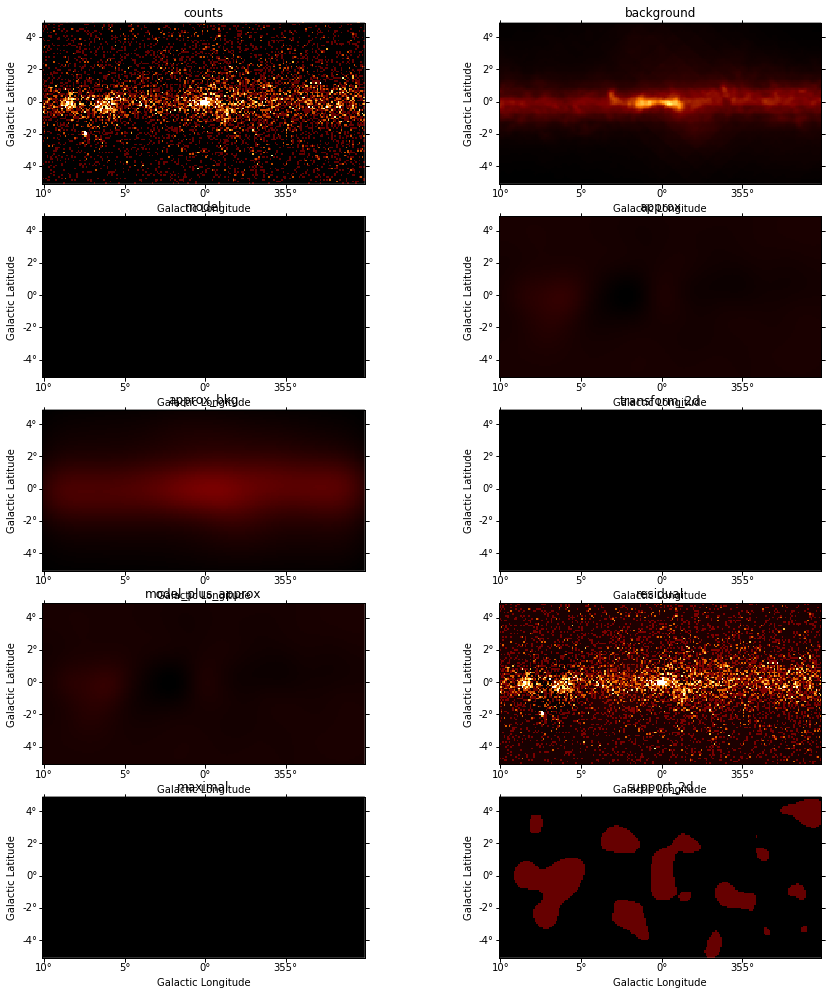

In [33]:
fig = plt.figure(figsize=FIG_SIZE)
images_diff = difference.images()
for index, (name, image) in enumerate(images_diff.items()):
    ax = fig.add_subplot(
        len(images_diff), 2, index + 1, projection=image.geom.wcs
    )
    image.plot(vmax=PLOT_VALUE_MAX, fig=fig, ax=ax)
    plt.title(name)  # Maybe add a Name in SkyImage.plots?

You can save the results if you want

In [ ]:
# cwt_data.write('test-cwt.fits', True)